In [100]:
# Import modules
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

# Modules required for example 4
import folium
import clipboard # !pip install clipboard

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [3]:
# Define function to create dataframe from GEE data
def array_to_df(arr):
    """Function to convert list into dataframe"""
    df = pd.DataFrame(arr[1:])
    df.columns = arr[0]
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    return df

## Example 1: Tallgrass prairie vegetation index

Retrive and plot the enhanced vegetation index (EVI) for a point under grassland vegetation at the Konza Prairie

**Product**: [MODIS](/MCD43A4_006_EVIhttps://developers.google.com/earth-engine/datasets/catalog/MODIS_MCD43A4_006_EVI?hl=en)

In [28]:
# Get collection for Modis 16-day
MCD43A4 = ee.ImageCollection('MODIS/MCD43A4_006_EVI').filterDate('2021-01-01','2021-12-31')
EVI = MCD43A4.select('EVI')


In [ ]:
# Run this line to explore dataset details (output is long!)
pprint(EVI.getInfo())

In [6]:
# Define point of interest
konza_point = ee.Geometry.Point([-96.556316, 39.084535])


In [7]:
# Get data for region
konza_evi = EVI.getRegion(konza_point, scale=1).getInfo()


In [ ]:
# Run this line to inspect retrieved data (output is long!)
pprint(konza_evi)

In [9]:
# Convert array into dataframe
df_konza = array_to_df(konza_evi)

# Save dataframe as a .CSV file
# df.to_csv('modis_evi.csv', index=False)

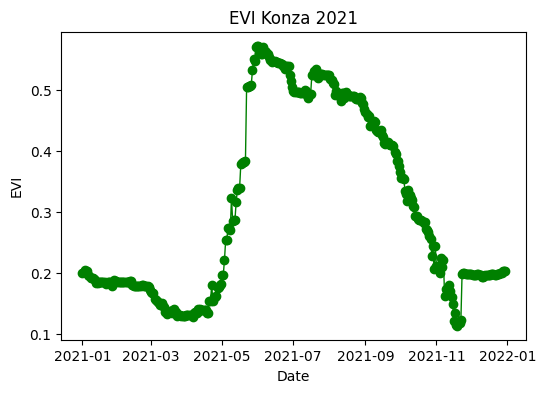

In [13]:
# Create figure to visualize time series
plt.figure(figsize=(6,4))
plt.title('EVI Konza 2021')
plt.plot(df_konza['time'], df_konza['EVI'], linestyle='-', 
         linewidth=1, marker='o', color='green')
plt.xlabel('Date')
plt.ylabel('EVI')
#plt.savefig('evi_figure.png', dpi=300)
plt.show()


## Example 2: Drought index

Drought can be represented by a variety of indices, including soil moisture, potential atmopsheric demand, days without measurable precipitation, and indices that combine one or more of these variables. The Evaporative Demand Drought Index (EDDI) is inteded to represent the potential for drought (rather than the actual occurrence of drought).

In this exercise we will compare drought conditions for eastern and western Kansas during  2021 and 2022.

Product: [GRIDMET DROUGHT](https://developers.google.com/earth-engine/datasets/catalog/GRIDMET_DROUGHT)


In [15]:
# Define locations
eastern_ks = ee.Geometry.Point([-95.317201, 38.588548]) # Near Ottawa, KS
western_ks = ee.Geometry.Point([-101.721117, 38.517258]) # Near Tribune, KS


In [20]:
# Load EDDI product
gridmet_drought = ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2021-01-01','2022-12-31')
eddi = gridmet_drought.select('eddi14d')


In [21]:
# Get eddie for points
eastern_eddi = eddi.getRegion(eastern_ks, scale=1).getInfo()
western_eddi = eddi.getRegion(western_ks, scale=1).getInfo()


In [22]:
# Explore output
eastern_eddi[0:3]

[['id', 'longitude', 'latitude', 'time', 'eddi14d'],
 ['20210105',
  -95.31720298383848,
  38.588547875926515,
  1609826400000,
  -0.029999999329447746],
 ['20210110',
  -95.31720298383848,
  38.588547875926515,
  1610258400000,
  -1.0099999904632568]]

In [23]:
# Create dataframe for each point
df_eastern = array_to_df(eastern_eddi)
df_western = array_to_df(western_eddi)

# Display a few rows
df_eastern.head()

# Save data to a comma-separated value file
# df.to_csv('eddi_14_day.csv', index=False)

,id,longitude,latitude,time,eddi14d
0,20210105,-95.317203,38.588548,2021-01-05 06:00:00,-0.03
1,20210110,-95.317203,38.588548,2021-01-10 06:00:00,-1.01
2,20210115,-95.317203,38.588548,2021-01-15 06:00:00,-0.03
3,20210120,-95.317203,38.588548,2021-01-20 06:00:00,0.39
4,20210125,-95.317203,38.588548,2021-01-25 06:00:00,0.39


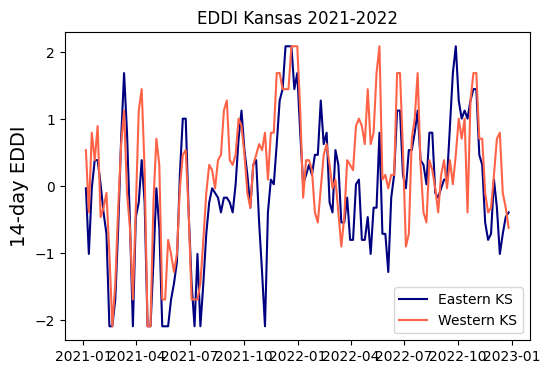

In [95]:
# Create figure to compare EDDI for both points
plt.figure(figsize=(6,4))
plt.title('EDDI Kansas 2021-2022')
plt.plot(df_eastern['time'], df_eastern['eddi14d'], linestyle='-', color='navy', label='Eastern KS')
plt.plot(df_western['time'], df_western['eddi14d'], linestyle='-', color='tomato', label='Western KS')
plt.legend()
plt.ylabel('14-day EDDI', size=14)
plt.show()


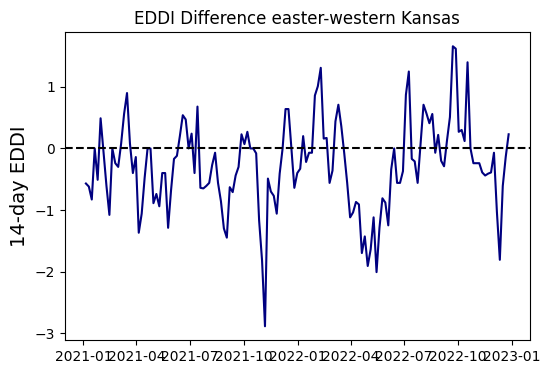

In [94]:
# Compute difference. If negative, that means that drought potential is greater in
# western Kansas

plt.figure(figsize=(6,4))
plt.title('EDDI Difference easter-western Kansas')
plt.plot(df_eastern['time'], df_eastern['eddi14d']-df_western['eddi14d'], linestyle='-', color='navy')
plt.axhline(0, linestyle='--', color='k')
plt.ylabel('14-day EDDI', size=14)
plt.show()


## Example 3: Irrigated vs rainfed corn vegetation index

In [83]:
# Define points
data = {'latitude': [38.7640, 38.7628, 38.7787, 38.7642, 38.7162, 38.7783],
        'longitude':[-101.8946, -101.8069, -101.6937, -101.9922, -101.8284, -101.9919],
        'irrigated':[True, True, True, False, False, False]}

df = pd.DataFrame(data)
df.head()


,latitude,longitude,irrigated
0,38.7640,-101.8946,True
1,38.7628,-101.8069,True
2,38.7787,-101.6937,True
3,38.7642,-101.9922,False
4,38.7162,-101.8284,False


In [88]:
# Get product
MOD13Q1 = ee.ImageCollection("MODIS/061/MOD13Q1").filterDate(ee.Date("2022-04-01"),ee.Date("2022-11-15"))


Since in this particular exercise we have multiple locations, one simple solution is to iterate over each point and request the time series of NDVI.

In [89]:
# Iterate over each point and retrieve NDVI
ndvi={}

for k, row in df.iterrows():
    point = ee.Geometry.Point(row['longitude'], row['latitude'])
    result = MOD13Q1.select('NDVI').getRegion(point, 0.01).getInfo()
    result_in_colums = np.transpose(result)
    ndvi[f"field_{k+1}"] = result_in_colums[4][1:]
    dates = result_in_colums[0][1:]
    

In [90]:
# Create Dataframe with the NDVI data for each field
df_ndvi = pd.DataFrame(ndvi,dtype=float)

# Add dates as index
df_ndvi.index = pd.to_datetime(dates, format='%Y_%m_%d')

# Apply conversion factor
df_ndvi = df_ndvi*0.0001

df_ndvi.head()

,field_1,field_2,field_3,field_4,field_5,field_6
2022-04-07,0.1933,0.2024,0.2222,0.2934,0.2032,0.2007
2022-04-23,0.2118,0.2178,0.1972,0.2785,0.2104,0.2107
2022-05-09,0.1824,0.2039,0.2220,0.2328,0.1959,0.1827
2022-05-25,0.2440,0.2056,0.2632,0.2115,0.1943,0.1902
2022-06-10,0.3325,0.2236,0.2235,0.2186,0.2033,0.2054


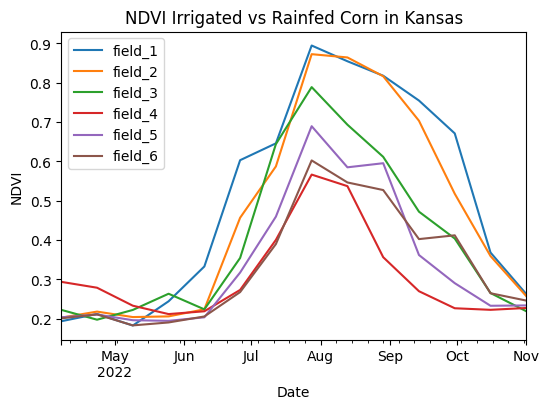

In [93]:
df_ndvi.plot(figsize=(6,4))
plt.title('NDVI Irrigated vs Rainfed Corn in Kansas')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.show()

## Example 4: Interactive selection
In this example we will leverage the interactive functionality of the Folium library and the computer's clipboard to get geographic coordinates with a mouse click and then retrieve time series of a vegetation index using GEE.

In [96]:
# Define function to create raster map
# Declare a function (blueprint)
def create_raster(ee_object, vis_params, name):
    """Function that creates a folium raster layer"""
    raster = folium.raster_layers.TileLayer(ee_object.getMapId(vis_params)['tile_fetcher'].url_format,
                                       name=name,
                                       overlay=True,
                                       control=True,
                                       attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>')
    return raster

In [97]:
# US Counties dataset
US_counties = ee.FeatureCollection("TIGER/2018/Counties") 

# Select county of interest
state_FIP = '20'
county_name = 'Thomas'
county = US_counties.filter(ee.Filter.eq('STATEFP','20').And(ee.Filter.eq('NAME','Thomas')).And(ee.Filter.eq('GEOID','20193')))
county_meta = county.getInfo()


In [118]:
### Select cropland datalayer ###
start_date = '2018-01-01'
end_date = '2018-12-31'
CDL = ee.ImageCollection('USDA/NASS/CDL').filter(ee.Filter.date(start_date,end_date)).first()
cropland = CDL.select('cropland')

# Clip cropland layer to selected county
county_cropland = cropland.clip(county)


### Select vegetation index (vi) ###
band = 'EVI' # or 'NDVI'

# Define start and end of time series for vegetation index
start_date_vi = '2017-10-15'
end_date_vi = '2018-06-15'

# Request dataset and band
MCD43A4 = ee.ImageCollection('MODIS/MCD43A4_006_EVI').filterDate(start_date_vi,end_date_vi)
vi = MCD43A4.select('EVI')


In [129]:
# Get county boundaries
location_lat = float(county_meta['features'][0]['properties']['INTPTLAT'])
location_lon = float(county_meta['features'][0]['properties']['INTPTLON'])

# Visualize county boundaries
m = folium.Map(location=[location_lat, location_lon], zoom_start=10)

# Add click event to paste coordinates into the clipboard
m.add_child(folium.ClickForLatLng(alert=False))
m.add_child(folium.LatLngPopup())

# Create raster using function defined earlier and add map
create_raster(county_cropland, {}, 'cropland').add_to(m)
folium.GeoJson(county.getInfo(),
               name='County boundary',
        style_function=lambda feature: {
        'fillColor': 'None',
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }).add_to(m)

# Add some controls
folium.LayerControl().add_to(m)

# Display map
m


39.402244 -100.990448


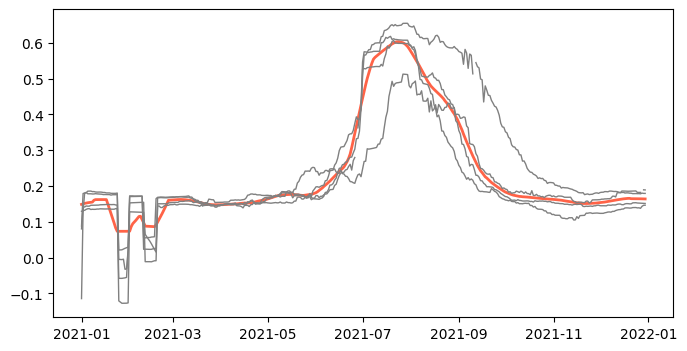

In [131]:
lat, lon = eval(clipboard.paste())
print(lat, lon)

# Define selected coordinates as point geometry
field_point = ee.Geometry.Point([lon, lat])

point_evi = EVI.getRegion(field_point, scale=1).getInfo()
df_point = array_to_df(point_evi)

if 'df' not in locals():
    df = df_point
else:
    df = pd.concat([df, df_point])
    
evi_mean = df.groupby(by='time', as_index=False)['EVI'].median()
evi_mean['smoothed'] = evi_mean['EVI'].rolling(window=15, min_periods=1, center=True).mean()

# Create figure
plt.figure(figsize=(8,4))
plt.plot(evi_mean['time'], evi_mean['smoothed'], color='tomato', linewidth=2)
for lat in df['latitude'].unique():
    idx = df['latitude'] == lat
    plt.plot(df.loc[idx,'time'], df.loc[idx,'EVI'], linestyle='-', linewidth=1, color='gray')

plt.show()